# GMM Classification Experiments 


We experiment with 2D logistic models.

In [1]:
%load_ext autoreload
%autoreload 2


import torch
from torch import nn
from copy import deepcopy
import matplotlib.pyplot as plt
from layered_unlearning.utils import set_seed
from layered_unlearning.gmm_classification import (
    Gaussian,
    GaussianMixture,
    LogisticModel,
    Uniform,
    train,
    evaluate,
    construct_dataset,
)
import seaborn as sns
from pathlib import Path
from typing import Dict, List
import pandas as pd
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import numpy as np
from matplotlib.patches import Patch

seed = set_seed(1)

## Hyperparameters
Default hyperparameters for our experiments. 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_epochs = 3
lr = 1e-2
batch_size = 32
n_classes = 2
n_samples = 5000
dim = 2
weight_decay = 0.0
weight_delta_penalty = 0.0

rbf = True
rbf_sigma = 8
rbf_width = 60
rbf_num = 12
degree = 0

eps = 1e-8
n_layers = 0
batch_norm = True
hidden_dim = 128

loss_type = "cross_entropy"

cov_scale = 4
cov_perturb = 0.1
mu_width = 50
uniform_half_width = 60
n_classes = 5
clustering = "random"  # random, k-means, adversarial


def mu_gen():
    return torch.rand((dim,)) * 2 * mu_width - mu_width


def cov_gen():
    base = torch.eye(dim) * cov_scale
    U = torch.randn((dim, dim))
    perturb = U.T @ U * cov_perturb
    return base + perturb


def get_gaussian_mixture(
    n_classes: int,
    mu_list: List[torch.Tensor] = None,
    cov_list: List[torch.Tensor] = None,
) -> GaussianMixture:
    classes = []
    for i in range(n_classes):
        classes.append(
            Gaussian(
                mu=mu_gen() if mu_list is None else mu_list[i],
                cov=cov_gen() if cov_list is None else cov_list[i],
            )
        )

    mixture = GaussianMixture(
        classes=classes,
        weights=torch.ones(n_classes) / n_classes,
    )
    return mixture


def get_even_clusters(X: np.ndarray, cluster_size: int):
    n_clusters = int(np.ceil(len(X) / cluster_size))
    kmeans = KMeans(n_clusters)
    kmeans.fit(X)
    centers = kmeans.cluster_centers_
    centers = (
        centers.reshape(-1, 1, X.shape[-1])
        .repeat(cluster_size, 1)
        .reshape(-1, X.shape[-1])
    )
    distance_matrix = cdist(X, centers)
    clusters = linear_sum_assignment(distance_matrix)[1] // cluster_size
    return clusters


mean_lists = []
for i in range(3):
    for j in range(n_classes):
        mean_lists.append(mu_gen())
if clustering == "random":
    mean_lists = torch.stack(mean_lists).reshape(3, n_classes, dim)
elif clustering == "k-means":
    all_means = torch.cat(mean_lists, dim=0)
    all_means = all_means.reshape(-1, dim)
    labels = get_even_clusters(all_means.numpy(), n_classes)
    mean_lists = []
    for i in range(3):
        filtered = all_means[labels == i]
        filtered = torch.tensor(filtered)
        mean_lists.append(filtered)
    mean_lists = torch.stack(mean_lists).reshape(3, n_classes, dim)
elif clustering == "adversarial":
    all_means = torch.cat(mean_lists, dim=0)
    all_means = all_means.reshape(-1, dim)
    labels = get_even_clusters(all_means.numpy(), n_classes)
    better_means = [[] for _ in range(3)]
    mean_lists = []
    for i in range(3):
        filtered = all_means[labels == i]
        filtered = torch.tensor(filtered)
        mean_lists.append(filtered)
    mean_lists = torch.stack(mean_lists).reshape(3 * n_classes, dim)
    for i in range(3 * n_classes):
        better_means[i % 3].append(mean_lists[i])
    for i in range(3):
        better_means[i] = torch.stack(better_means[i])
    mean_lists = better_means
    mean_lists = torch.stack(mean_lists).reshape(3, n_classes, dim)
else:
    raise ValueError(f"Unknown clustering method: {clustering}")

gaussians = [
    Uniform(
        low=torch.tensor([-1.0, -1.0]) * uniform_half_width,
        high=torch.tensor([1.0, 1.0]) * uniform_half_width,
    ),
]

for i in range(3):
    gaussians.append(
        get_gaussian_mixture(
            n_classes=n_classes,
            mu_list=mean_lists[i],
        )
    )

# null, task A, task B, retain

X_full = [g.sample(n_samples) for g in gaussians]

/mnt/align4_drive/tcqian/layered-unlearning/src/layered_unlearning/gmm_classification/dataset.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.weights), n_samples, replacement=True
/mnt/align4_drive/tcqian/layered-unlearning/src/layered_unlearning/gmm_classification/dataset.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.weights), n_samples, replacement=True


## Training
We train the initial model, the base unlearned model, and the Layered Unlearning (LU) version of the base unlearned model. 

In [3]:
model_checkpoints = {}
evals = {}


def get_model(old_model: nn.Module = None):
    model = LogisticModel(
        dim=dim,
        n_classes=n_classes,
        degree=degree,
        rbf=rbf,
        rbf_sigma=rbf_sigma,
        rbf_width=rbf_width,
        rbf_num=rbf_num,
        n_layers=n_layers,
        batch_norm=batch_norm,
        hidden_dim=hidden_dim,
    ).to(device)
    if old_model is not None:
        model.load_state_dict(old_model.state_dict())
    return model


def global_train(
    model: nn.Module,
    learn_A: bool,
    learn_B: bool,
    relearn: bool = False,
    kwargs: Dict = {},
):
    X, y = construct_dataset(
        X_full, learn_A=learn_A, learn_B=learn_B, relearn=relearn, n_samples=n_samples
    )
    init_kwargs = {
        "eps": eps,
        "n_epochs": n_epochs,
        "lr": lr,
        "batch_size": batch_size,
        "weight_decay": weight_decay,
        "device": device,
        "loss_type": loss_type,
    }
    init_kwargs.update(kwargs)
    model = train(
        model,
        X,
        y,
        **init_kwargs,
    )
    return model


def global_eval(model: nn.Module, kwargs: Dict = {}):
    accuracies = []
    for i in range(1, 4):
        X = X_full[i]
        y = torch.ones(n_samples)
        if i == 3:
            X = torch.cat([X_full[0], X])
            y = torch.cat([torch.zeros(n_samples), y])
        acc = evaluate(model, X, y, device=device, batch_size=batch_size, **kwargs)
        accuracies.append(acc)
    return accuracies


def run(
    start: str,
    end: str,
    learn_A: bool,
    learn_B: bool,
    relearn: bool = False,
    train_kwargs: Dict = {},
    eval_kwargs: Dict = {},
):
    assert start is None or start in model_checkpoints
    model = get_model(model_checkpoints.get(start))
    model = global_train(
        model, learn_A=learn_A, learn_B=learn_B, relearn=relearn, kwargs=train_kwargs
    )
    evals[end] = global_eval(model, kwargs=eval_kwargs)
    print(
        f"{end}, A: {evals[end][0]:.2f}, B: {evals[end][1]:.2f}, Retain: {evals[end][2]:.2f}"
    )
    model_checkpoints[end] = deepcopy(model)


def run_relearn(name: str, train_kwargs: Dict = {}, eval_kwargs: Dict = {}):
    run(
        name,
        f"{name}-A",
        learn_A=True,
        learn_B=False,
        relearn=True,
        train_kwargs=train_kwargs,
        eval_kwargs=eval_kwargs,
    )
    run(
        name,
        f"{name}-B",
        learn_A=False,
        learn_B=True,
        relearn=True,
        train_kwargs=train_kwargs,
        eval_kwargs=eval_kwargs,
    )


run(None, "init", learn_A=True, learn_B=True)
run("init", "base", learn_A=False, learn_B=False)
run("init", "base-lu-partial", learn_A=False, learn_B=True)
run("base-lu-partial", "base-lu", learn_A=False, learn_B=False)
run_relearn("base")
run_relearn("base-lu")

Epoch 3/3: 100%|██████████| 625/625 [00:01<00:00, 501.66it/s, loss=0.274] 


init, A: 1.00, B: 1.00, Retain: 0.89


Epoch 3/3: 100%|██████████| 625/625 [00:01<00:00, 541.36it/s, loss=0.126] 


base, A: 0.07, B: 0.00, Retain: 0.95


Epoch 3/3: 100%|██████████| 625/625 [00:01<00:00, 580.05it/s, loss=0.138] 


base-lu-partial, A: 0.11, B: 0.98, Retain: 0.91


Epoch 3/3: 100%|██████████| 625/625 [00:01<00:00, 564.55it/s, loss=0.0575]


base-lu, A: 0.07, B: 0.00, Retain: 0.94


Epoch 3/3: 100%|██████████| 157/157 [00:00<00:00, 577.99it/s, loss=0.0292]


base-A, A: 1.00, B: 0.99, Retain: 0.83


Epoch 3/3: 100%|██████████| 157/157 [00:00<00:00, 589.10it/s, loss=0.0395]


base-B, A: 1.00, B: 1.00, Retain: 0.84


Epoch 3/3: 100%|██████████| 157/157 [00:00<00:00, 508.63it/s, loss=0.232] 


base-lu-A, A: 0.98, B: 1.00, Retain: 0.81


Epoch 3/3: 100%|██████████| 157/157 [00:00<00:00, 506.04it/s, loss=0.0394]


base-lu-B, A: 0.47, B: 1.00, Retain: 0.86


## Visualizations
We visualize decision boundaries learned and the resulting model.

In [4]:
df_dict = [
    {
        "name": name,
        "A": result[0],
        "B": result[1],
        "retain": result[2],
    }
    for name, result in evals.items()
]


df = pd.DataFrame(df_dict)

In [5]:
# Set consistent fonts and style globally
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["DejaVu Serif", "Times New Roman", "serif"]
plt.rcParams["text.usetex"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
sns.set_theme(
    style="whitegrid", rc={"font.family": "serif", "font.serif": ["Palatino Linotype"]}
)


def visualize(
    name: str,
    n_grid: int = 100,
    n_samples: int = None,
    output_path: Path = None,
    include_scatter: bool = True,
):
    model = model_checkpoints[name]
    model.eval()

    # Plot limits
    width = 60
    x_min, x_max = -width, width
    y_min, y_max = -width, width

    # Meshgrid
    xx, yy = torch.meshgrid(
        torch.linspace(x_min, x_max, n_grid),
        torch.linspace(y_min, y_max, n_grid),
        indexing="ij",  # Required for compatibility with torch >= 1.10
    )
    grid = torch.stack([xx.ravel(), yy.ravel()], dim=1).to(device)

    with torch.no_grad():
        grid_out = model(grid).squeeze().cpu()

    # Plot decision boundary
    fig, ax = plt.subplots(figsize=(8, 6))
    contour = ax.contourf(
        xx.cpu(),
        yy.cpu(),
        grid_out.reshape(xx.shape),
        levels=[0, 0.5, 1],
        alpha=0.2,
        cmap="coolwarm",
    )

    # Helper scatter function
    def scatter(
        x: torch.Tensor, y: torch.Tensor, color: str, label: str, n_samples: int = 1000
    ):
        if x.shape[0] > n_samples:
            indices = torch.randperm(x.shape[0])[:n_samples]
            x, y = x[indices], y[indices]
        ax.scatter(x.cpu(), y.cpu(), s=4, color=color, label=label, alpha=0.5)

    if include_scatter:
        frac = 0.25
        small_samples = int(n_samples * frac)
        scatter(
            X_full[0][:, 0],
            X_full[0][:, 1],
            color="blue",
            label="Null",
            n_samples=n_samples,
        )
        scatter(
            X_full[1][:, 0],
            X_full[1][:, 1],
            color="orange",
            label="A",
            n_samples=small_samples,
        )
        scatter(
            X_full[2][:, 0],
            X_full[2][:, 1],
            color="green",
            label="B",
            n_samples=small_samples,
        )
        scatter(
            X_full[3][:, 0],
            X_full[3][:, 1],
            color="red",
            label="Retain",
            n_samples=n_samples,
        )

    # Format plot
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel("Feature 1", fontsize=20, fontweight="bold")
    ax.set_ylabel("Feature 2", fontsize=20, fontweight="bold")

    if include_scatter:
        # Create scatter legend
        scatter_handles, scatter_labels = ax.get_legend_handles_labels()

        # Create contour legend entries manually
        contour_handles = [
            Patch(facecolor="blue", alpha=0.2, label="Class 0"),
            Patch(facecolor="red", alpha=0.2, label="Class 1"),
        ]

        # Combine legends
        ax.legend(
            handles=contour_handles + scatter_handles,
            title="Legend",
            fontsize=16,
            title_fontsize=16,
            frameon=True,
            framealpha=0.9,
            loc="upper right",
        )

    ax.tick_params(axis="both", which="major", width=1, length=5)
    ax.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    if output_path is not None:
        plt.savefig(output_path, dpi=300, bbox_inches="tight")
    else:
        plt.show()
    plt.close()


base_dir = Path("./gmm_figures")
base_dir.mkdir(exist_ok=True)

X, y = construct_dataset(X_full, learn_A=True, learn_B=True, n_samples=n_samples)
for name in model_checkpoints:
    visualize(
        name,
        n_grid=100,
        n_samples=1000,
        output_path=base_dir / f"{name}.svg",
    )
    plt.close()

[-0.44033119082450867, -1.4779964685440063, -2.0787389278411865, -2.6629090309143066, -0.026059504598379135, -0.50892573595047]


/tmp/ipykernel_2423087/2329349743.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # Make room for colorbar


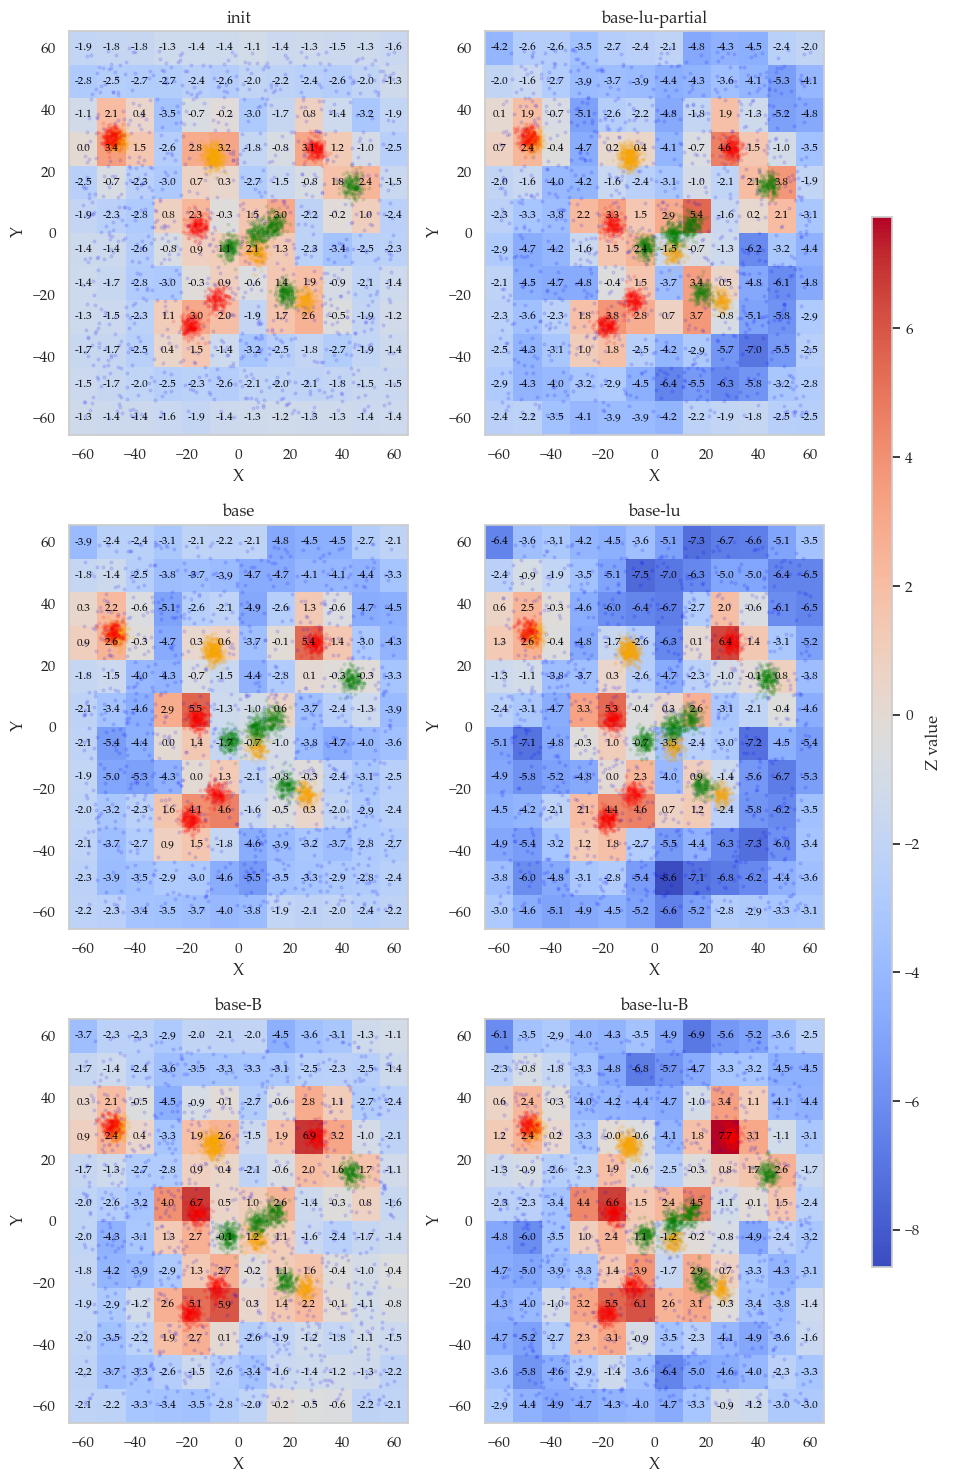

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def plot_multiple_heatmaps(datasets, z_values, labels, nrows, ncols, cmap='viridis', annotate=True):
    """
    Plot multiple heatmaps in a nrows x ncols grid, with shared color scale and optional annotations.

    Args:
        datasets (list of np.ndarray): list of (N^2, 2) arrays of (x, y) coordinates
        z_values (list of np.ndarray): list of (N^2,) arrays of z values
        labels (list of str): labels for each heatmap
        nrows (int): number of rows in the figure
        ncols (int): number of columns in the figure
        cmap (str): matplotlib colormap name
        annotate (bool): whether to add text labels inside the squares
    """
    num_plots = len(datasets)
    assert num_plots <= nrows * ncols, "Not enough slots for all plots!"

    # Find global vmin and vmax across all z
    all_z = np.concatenate(z_values)
    vmin, vmax = all_z.min(), all_z.max()

    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows), squeeze=False)
    
    for idx, (data, z, label) in enumerate(zip(datasets, z_values, labels)):
        row = idx // ncols
        col = idx % ncols
        
        ax = axes[row, col]
        x = data[:, 0]
        y = data[:, 1]
        N = int(np.sqrt(len(data)))

        x_grid = x.reshape(N, N)
        y_grid = y.reshape(N, N)
        z_grid = z.reshape(N, N)

        pcm = ax.pcolormesh(x_grid, y_grid, z_grid, shading='auto', cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(label)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

        if annotate:
            for i in range(N):
                for j in range(N):
                    x_center = (x_grid[i, j] + (x_grid[i, j+1] if j+1 < N else x_grid[i, j])) / 2
                    y_center = (y_grid[i, j] + (y_grid[i+1, j] if i+1 < N else y_grid[i, j])) / 2
                    ax.text(x_center, y_center, f"{z_grid[i, j]:.1f}",
                            ha='center', va='center', color='black', fontsize=8)
        # also scatter the points X_full, same as the original code
        def scatter(
            x: torch.Tensor, y: torch.Tensor, color: str, label: str, n_samples: int = 1000
        ):
            if x.shape[0] > n_samples:
                indices = torch.randperm(x.shape[0])[:n_samples]
                x, y = x[indices], y[indices]
            ax.scatter(x.cpu(), y.cpu(), s=4, color=color, label=label, alpha=0.1)
        # Scatter the original data points
        scatter(
            X_full[0][:, 0],
            X_full[0][:, 1],
            color="blue",
            label="Null",
            n_samples=1000,
        )
        scatter(
            X_full[1][:, 0],
            X_full[1][:, 1],
            color="orange",
            label="A",
            n_samples=1000,
        )
        scatter(
            X_full[2][:, 0],
            X_full[2][:, 1],
            color="green",
            label="B",
            n_samples=1000,
        )
        scatter(
            X_full[3][:, 0],
            X_full[3][:, 1],
            color="red",
            label="Retain",
            n_samples=1000,
        )


    # Turn off unused subplots
    for idx in range(num_plots, nrows * ncols):
        row = idx // ncols
        col = idx % ncols
        axes[row, col].axis('off')

    # Add a single global colorbar
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    fig.colorbar(pcm, cax=cbar_ax, label='Z value')

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Make room for colorbar
    plt.savefig("heatmaps.png", dpi=300, bbox_inches="tight")


model_names = ["init", "base-lu-partial", "base", "base-lu", "base-B", "base-lu-B", ]
datasets = [model_checkpoints[name].rbf for name in model_names]
z_values = [model_checkpoints[name].layers[-1].weight.detach().reshape(-1).cpu().numpy() for name in model_names]
biases = [model_checkpoints[name].layers[-1].bias.detach().reshape(-1).cpu().numpy().item() for name in model_names]
print(biases)
plot_multiple_heatmaps(datasets, z_values, model_names, 3, 2, cmap='coolwarm')
